In [71]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/restaurant-revenue-prediction/train.csv.zip
/kaggle/input/restaurant-revenue-prediction/test.csv.zip
/kaggle/input/restaurant-revenue-prediction/sampleSubmission.csv


In [72]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [73]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV,  RandomizedSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import lightgbm as lgb

In [74]:
train = pd.read_csv('../input/restaurant-revenue-prediction/train.csv.zip')
test = pd.read_csv('../input/restaurant-revenue-prediction/test.csv.zip')

In [75]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [76]:
train

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,132,06/25/2008,Trabzon,Other,FC,2,3.0,3.0,5.0,4,...,3.0,0,0,0,0,0,0,0,0,5787594.0
133,133,10/12/2006,İzmir,Big Cities,FC,4,5.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,9262754.0
134,134,07/08/2006,Kayseri,Other,FC,3,4.0,4.0,4.0,2,...,3.0,0,0,0,0,0,0,0,0,2544857.0
135,135,10/29/2010,İstanbul,Big Cities,FC,4,5.0,4.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,7217634.0


In [77]:
test

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,01/05/2000,Antalya,Other,FC,5,5.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
99996,99996,07/18/2011,Niğde,Other,IL,1,2.0,4.0,3.0,1,...,1.0,3.0,5,0,0,0,4,0,0,0
99997,99997,12/29/2012,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,1,...,4.0,1.0,5,5,3,2,4,4,4,2
99998,99998,10/12/2013,İstanbul,Big Cities,FC,12,7.5,6.0,6.0,4,...,7.5,5.0,0,0,0,4,0,0,0,0


In [78]:
def dayofyear(x):
    t = x.values
    y=[None]*len(t)
    P = [1,3, 5,7,8,10,12]
    I = [4,6,9,11]
    for i in range(len(t)):
        a = t[i]
        b = 0
        c= int(a[:2])-1
        while c> 0 :
            if c in P:
                b =b+ 31
            if c in I:
                b=b+30
            if c ==2:
                if int(a[6:10])%4 ==0:
                    if int(a[6:10])%100 ==0: 
                        if int(a[6:10])%400 ==0: b=b+29
                        else : b=b+28 
                    else :  b=b+29
                        
                else :  b=b+28
            c = c -1
        y[i]=b+int(a[3:5])
    return(pd.DataFrame(y))

In [79]:
def theyear(x):
    t = x.values
    y=[None]*len(t)
    for i in range(0,len(t)):
        a = t[i]
        c= int(a[6:10])
        y[i] = c
    return(pd.DataFrame(y))

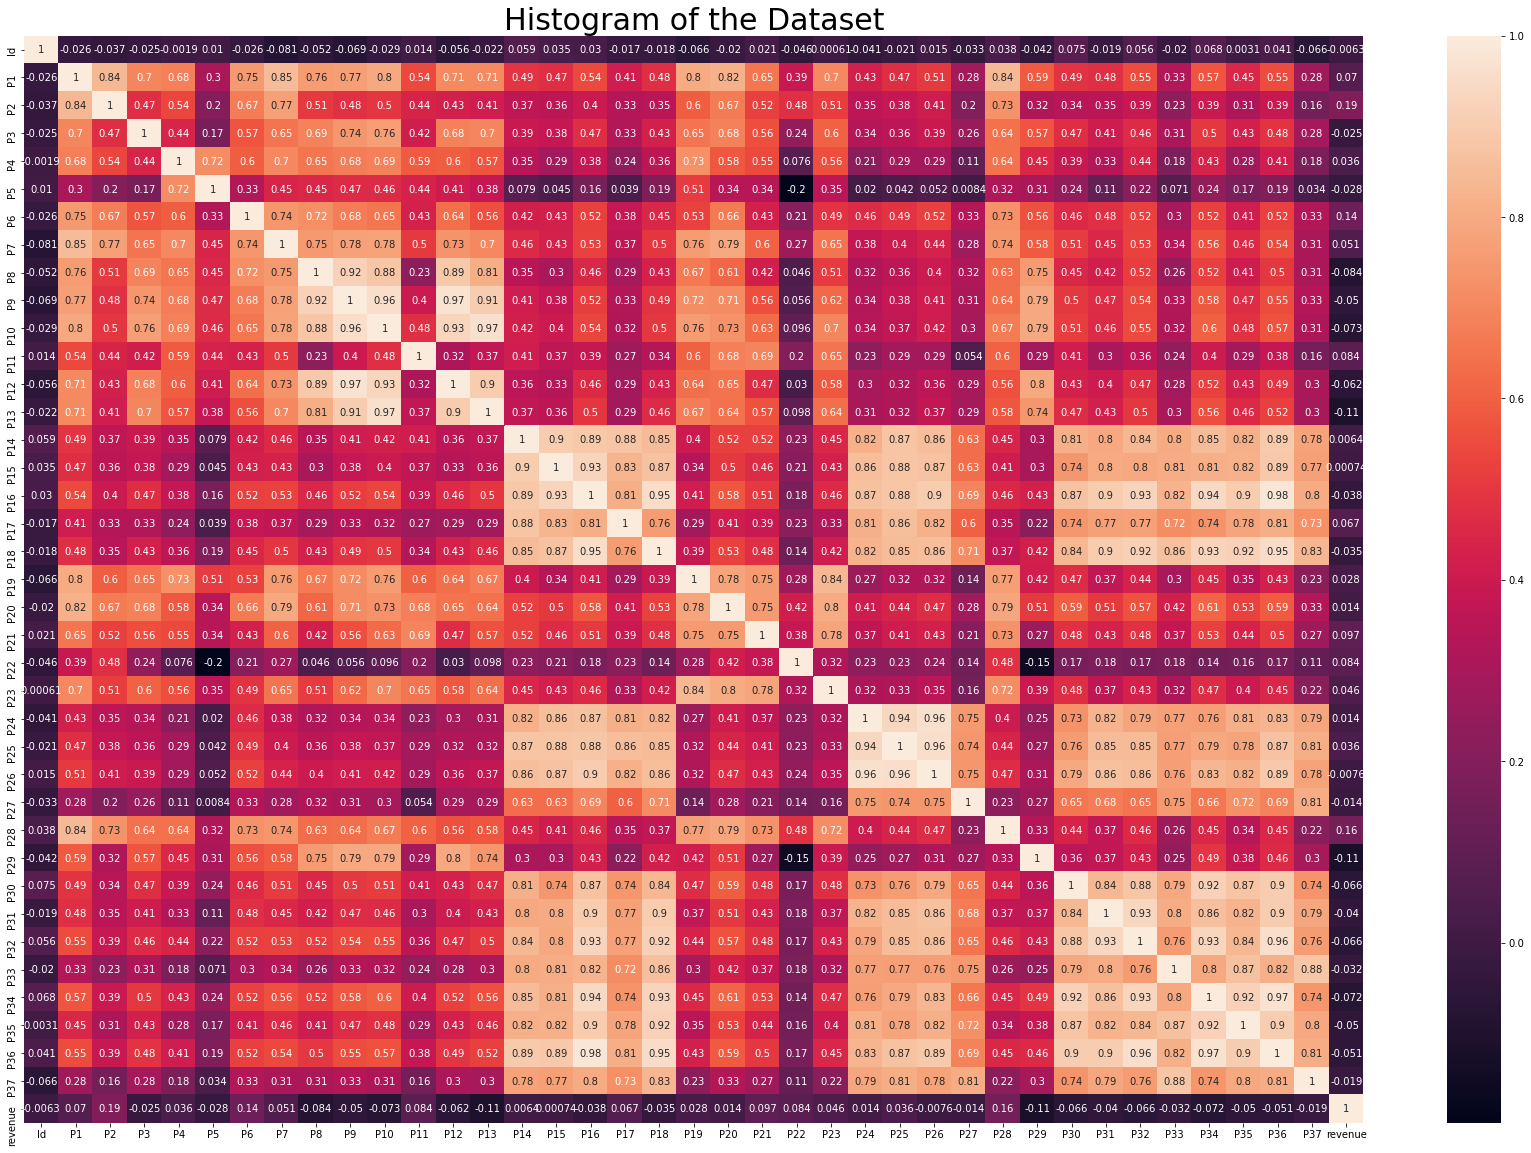

In [80]:
plt.rcParams['figure.figsize'] = (30, 20)
sns.heatmap(train.corr(), annot = True)

plt.title('Histogram of the Dataset', fontsize = 30)
plt.show()

In [81]:
def pre(tr):
    tr['Day'] = dayofyear(tr['Open Date'])
    tr['Year'] = theyear(tr['Open Date'])
    tr.drop(('Open Date'), axis=1, inplace=True)
    df =pd.get_dummies(tr[['City Group','Type']], drop_first=True)
    tr['City Group_Other']=df['City Group_Other']
    tr['Type_FC']=df['Type_FC']
    tr['Type_IL']=df['Type_IL']
    tr.drop(('Type'), axis=1, inplace=True)
    tr.drop(('City Group'), axis=1, inplace=True)
    tr.drop(('Id'), axis=1, inplace=True)
    tr.drop(('City'), axis=1, inplace=True)
    
    return(tr)

In [82]:
tr = pre(train)

In [83]:
tr = tr[tr.columns[:37].tolist()+tr.columns[38:].tolist()+['revenue']]

In [84]:
data = tr
for y in tr.columns :
  factor = 4
  upper_lim = data[y].mean () + data[y].std () * factor
  lower_lim = data[y].mean () - data[y].std () * factor
  data = data[(data[y] < upper_lim) & (data[y] > lower_lim)]

In [85]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
sc = StandardScaler()
X_train[:, :39] = sc.fit_transform(X_train[:, :39])
X_test[:, :39] = sc.transform(X_test[:, :39])
sc2 = StandardScaler()
y_train = sc2.fit_transform(y_train.reshape(-1, 1))
y_test = sc2.transform(y_test.reshape(-1, 1)) 

In [86]:
data.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P34,P35,P36,P37,Day,Year,City Group_Other,Type_FC,Type_IL,revenue
0,4,5.0,4.0,4.0,2,2,5,4,5,5,...,5,4,3,4,198,1999,0,0,1,5653753.0
1,4,5.0,4.0,4.0,1,2,5,5,5,5,...,0,0,0,0,45,2008,0,1,0,6923131.0
2,2,4.0,2.0,5.0,2,3,5,5,5,5,...,0,0,0,0,68,2013,1,0,1,2055379.0
4,3,4.0,3.0,4.0,2,2,5,5,5,5,...,3,4,3,3,129,2009,1,0,1,4316715.0
6,2,3.0,4.0,4.0,1,5,5,5,5,5,...,3,5,4,4,284,2010,0,0,1,5166635.0


In [87]:
train_accuracies = {'Linear Regression':[0,0], 'Polynomial Regression':[0,0], 'Support Vector Regression' : [0,0] , 'Random Forest Regression':[0,0],
                    'Deision Tree Regression':[0,0] , 'XGBoost Regression':[0,0] , 'lightgbm Regressor' :[0,0] }
test_accuracies = {'Linear Regression':[0,0], 'Polynomial Regression':[0,0], 'Support Vector Regression' : [0,0] , 'Random Forest Regression':[0,0],
                    'Deision Tree Regression':[0,0] , 'XGBoost Regression':[0,0] , 'lightgbm Regressor' :[0,0] }

In [88]:
lr = LinearRegression()
lr.fit(X_train , y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)
scores1 = cross_val_score(lr, train_preds, y_train, scoring= 'neg_mean_squared_error', cv=10)
scores2 = cross_val_score(lr, test_preds, y_test, scoring= 'neg_mean_squared_error', cv=10)

In [89]:
print("Linear Regression results :")

print("   -   The Mean Squared Error on the train set : {:.7f}".format(np.sqrt(-scores1.mean())))
train_accuracies['Linear Regression'][0] = np.sqrt(-scores1.mean())
print("   -   The Mean Squared Error Deviation on the train set : {:.7f}".format(np.sqrt(scores1.std())))
train_accuracies['Linear Regression'][1] = np.sqrt(scores1.std())

print("   -   The Mean Squared Error on the test set : {:.2f}".format(np.sqrt(-scores2.mean())))
test_accuracies['Linear Regression'][0] = np.sqrt(-scores2.mean())
print("   -   The Mean Squared Error Deviation on the test set : {:.7f}".format(np.sqrt(scores2.std())))
test_accuracies['Linear Regression'][1] = np.sqrt(scores2.std())

Linear Regression results :
   -   The Mean Squared Error on the train set : 0.6176442
   -   The Mean Squared Error Deviation on the train set : 0.3788980
   -   The Mean Squared Error on the test set : 0.89
   -   The Mean Squared Error Deviation on the test set : 0.9765264


In [90]:
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(X_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)
train_preds = lin_reg_2.predict(X_poly)
test_preds = lin_reg_2.predict(poly_reg.fit_transform(X_test))
scores1 = cross_val_score(lr, train_preds, y_train, scoring= 'neg_mean_squared_error', cv=10)
scores2 = cross_val_score(lr, test_preds, y_test, scoring= 'neg_mean_squared_error', cv=10)


In [91]:
print("Polynomial Regression results :")

print("   -   The Mean Squared Error on the train set : {:.7f}".format(np.sqrt(-scores1.mean())))
train_accuracies['Polynomial Regression'][0] = np.sqrt(-scores1.mean())
print("   -   The Mean Squared Error Deviation on the train set : {:.7f}".format(np.sqrt(scores1.std())))
train_accuracies['Polynomial Regression'][1] = np.sqrt(scores1.std())

print("   -   The Mean Squared Error on the test set : {:.2f}".format(np.sqrt(-scores2.mean())))
test_accuracies['Polynomial Regression'][0] = np.sqrt(-scores2.mean())
print("   -   The Mean Squared Error Deviation on the test set : {:.7f}".format(np.sqrt(scores2.std())))
test_accuracies['Polynomial Regression'][1] = np.sqrt(scores2.std())

Polynomial Regression results :
   -   The Mean Squared Error on the train set : 0.0000000
   -   The Mean Squared Error Deviation on the train set : 0.0000000
   -   The Mean Squared Error on the test set : 0.90
   -   The Mean Squared Error Deviation on the test set : 1.0143663


In [92]:
train_accuracies

{'Linear Regression': [0.6176441585235596, 0.3788979851049833],
 'Polynomial Regression': [1.1995923833825202e-13, 1.5691337397658408e-13],
 'Support Vector Regression': [0, 0],
 'Random Forest Regression': [0, 0],
 'Deision Tree Regression': [0, 0],
 'XGBoost Regression': [0, 0],
 'lightgbm Regressor': [0, 0]}

In [93]:
sv = SVR(kernel = 'rbf')
sv.fit(X_train, y_train)
train_preds = sv.predict(X_train)
test_preds = sv.predict(X_test)
scores1 = cross_val_score(sv, X = train_preds.reshape(-1, 1), y = y_train.ravel(), scoring= 'neg_mean_squared_error', cv=10)
scores2 = cross_val_score(sv, X =  test_preds.reshape(-1, 1), y = y_test.ravel(), scoring= 'neg_mean_squared_error', cv=10)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [94]:
print("Support Vector Regression results :")

print("   -   The Mean Squared Error on the train set : {:.7f}".format(np.sqrt(-scores1.mean())))
train_accuracies['Support Vector Regression'][0] = np.sqrt(-scores1.mean())
print("   -   The Mean Squared Error Deviation on the train set : {:.7f}".format(np.sqrt(scores1.std())))
train_accuracies['Support Vector Regression'][1] = np.sqrt(scores1.std())

print("   -   The Mean Squared Error on the test set : {:.2f}".format(np.sqrt(-scores2.mean())))
test_accuracies['Support Vector Regression'][0] = np.sqrt(-scores2.mean())
print("   -   The Mean Squared Error Deviation on the test set : {:.7f}".format(np.sqrt(scores2.std())))
test_accuracies['Support Vector Regression'][1] = np.sqrt(scores2.std())

Support Vector Regression results :
   -   The Mean Squared Error on the train set : 0.6270315
   -   The Mean Squared Error Deviation on the train set : 0.4358484
   -   The Mean Squared Error on the test set : 0.93
   -   The Mean Squared Error Deviation on the test set : 1.1034136


In [95]:
dt = DecisionTreeRegressor()
dt.fit(X_train , y_train)
train_preds = dt.predict(X_train)
test_preds = dt.predict(X_test)
scores1 = cross_val_score(dt, X = train_preds.reshape(-1, 1), y = y_train.ravel(), scoring= 'neg_mean_squared_error', cv=10)
scores2 = cross_val_score(dt, X =  test_preds.reshape(-1, 1), y = y_test.ravel(), scoring= 'neg_mean_squared_error', cv=10)

In [96]:
print("Deision Tree Regression results :")

print("   -   The Mean Squared Error on the train set : {:.7f}".format(np.sqrt(-scores1.mean())))
train_accuracies['Deision Tree Regression'][0] = np.sqrt(-scores1.mean())
print("   -   The Mean Squared Error Deviation on the train set : {:.7f}".format(np.sqrt(scores1.std())))
train_accuracies['Deision Tree Regression'][1] = np.sqrt(scores1.std())

print("   -   The Mean Squared Error on the test set : {:.2f}".format(np.sqrt(-scores2.mean())))
test_accuracies['Deision Tree Regression'][0] = np.sqrt(-scores2.mean())
print("   -   The Mean Squared Error Deviation on the test set : {:.7f}".format(np.sqrt(scores2.std())))
test_accuracies['Deision Tree Regression'][1] = np.sqrt(scores2.std())

Deision Tree Regression results :
   -   The Mean Squared Error on the train set : 0.1960456
   -   The Mean Squared Error Deviation on the train set : 0.3210536
   -   The Mean Squared Error on the test set : 0.79
   -   The Mean Squared Error Deviation on the test set : 0.6506062


In [97]:
rf = RandomForestRegressor()
rf.fit(X_train , y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)
scores1 = cross_val_score(rf, X = train_preds.reshape(-1, 1), y = y_train.ravel(), scoring= 'neg_mean_squared_error', cv=10)
scores2 = cross_val_score(rf, X =  test_preds.reshape(-1, 1), y = y_test.ravel(), scoring= 'neg_mean_squared_error', cv=10)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [98]:
print("Random Forest Regression results :")

print("   -   The Mean Squared Error on the train set : {:.7f}".format(np.sqrt(-scores1.mean())))
train_accuracies['Random Forest Regression'][0] = np.sqrt(-scores1.mean())
print("   -   The Mean Squared Error Deviation on the train set : {:.7f}".format(np.sqrt(scores1.std())))
train_accuracies['Random Forest Regression'][1] = np.sqrt(scores1.std())

print("   -   The Mean Squared Error on the test set : {:.2f}".format(np.sqrt(-scores2.mean())))
test_accuracies['Random Forest Regression'][0] = np.sqrt(-scores2.mean())
print("   -   The Mean Squared Error Deviation on the test set : {:.7f}".format(np.sqrt(scores2.std())))
test_accuracies['Random Forest Regression'][1] = np.sqrt(scores2.std())

Random Forest Regression results :
   -   The Mean Squared Error on the train set : 0.4276245
   -   The Mean Squared Error Deviation on the train set : 0.3688500
   -   The Mean Squared Error on the test set : 1.17
   -   The Mean Squared Error Deviation on the test set : 1.0910204


In [99]:
gb = XGBRegressor()
gb.fit(X_train , y_train)
train_preds = gb.predict(X_train)
test_preds = gb.predict(X_test)
scores1 = cross_val_score(gb, X = train_preds.reshape(-1, 1), y = y_train.ravel(), scoring= 'neg_mean_squared_error', cv=10)
scores2 = cross_val_score(gb, X =  test_preds.reshape(-1, 1), y = y_test.ravel(), scoring= 'neg_mean_squared_error', cv=10)

In [100]:
print("XGBoost Regression results :")

print("   -   The Mean Squared Error on the train set : {:.7f}".format(np.sqrt(-scores1.mean())))
train_accuracies['XGBoost Regression'][0] = np.sqrt(-scores1.mean())
print("   -   The Mean Squared Error Deviation on the train set : {:.7f}".format(np.sqrt(scores1.std())))
train_accuracies['XGBoost Regression'][1] = np.sqrt(scores1.std())

print("   -   The Mean Squared Error on the test set : {:.2f}".format(np.sqrt(-scores2.mean())))
test_accuracies['XGBoost Regression'][0] = np.sqrt(-scores2.mean())
print("   -   The Mean Squared Error Deviation on the test set : {:.7f}".format(np.sqrt(scores2.std())))
test_accuracies['XGBoost Regression'][1] = np.sqrt(scores2.std())

XGBoost Regression results :
   -   The Mean Squared Error on the train set : 0.1962315
   -   The Mean Squared Error Deviation on the train set : 0.3212786
   -   The Mean Squared Error on the test set : 1.29
   -   The Mean Squared Error Deviation on the test set : 1.2202749


In [101]:
gbm = lgb.LGBMRegressor()
gbm.fit(X_train , y_train)
train_preds = gbm.predict(X_train)
test_preds = gbm.predict(X_test)
scores1 = cross_val_score(gbm, X = train_preds.reshape(-1, 1), y = y_train.ravel(), scoring= 'neg_mean_squared_error', cv=10)
scores2 = cross_val_score(gbm, X =  test_preds.reshape(-1, 1), y = y_test.ravel(), scoring= 'neg_mean_squared_error', cv=10)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [102]:
print("lightgbm Regressor results :")

print("   -   The Mean Squared Error on the train set : {:.7f}".format(np.sqrt(-scores1.mean())))
train_accuracies['lightgbm Regressor'][0] = np.sqrt(-scores1.mean())
print("   -   The Mean Squared Error Deviation on the train set : {:.7f}".format(np.sqrt(scores1.std())))
train_accuracies['lightgbm Regressor'][1] = np.sqrt(scores1.std())

print("   -   The Mean Squared Error on the test set : {:.2f}".format(np.sqrt(-scores2.mean())))
test_accuracies['lightgbm Regressor'][0] = np.sqrt(-scores2.mean())
print("   -   The Mean Squared Error Deviation on the test set : {:.7f}".format(np.sqrt(scores2.std())))
test_accuracies['lightgbm Regressor'][1] = np.sqrt(scores2.std())

lightgbm Regressor results :
   -   The Mean Squared Error on the train set : 0.7328816
   -   The Mean Squared Error Deviation on the train set : 0.5333989
   -   The Mean Squared Error on the test set : 0.88
   -   The Mean Squared Error Deviation on the test set : 0.9827247


In [103]:
train_accuracies

{'Linear Regression': [0.6176441585235596, 0.3788979851049833],
 'Polynomial Regression': [1.1995923833825202e-13, 1.5691337397658408e-13],
 'Support Vector Regression': [0.627031532422882, 0.43584836360035856],
 'Random Forest Regression': [0.42762447695830363, 0.36885002217970353],
 'Deision Tree Regression': [0.1960455833503336, 0.32105358462929984],
 'XGBoost Regression': [0.19623153238390909, 0.3212785701361746],
 'lightgbm Regressor': [0.7328815890355225, 0.5333989033018084]}

In [104]:
test_accuracies

{'Linear Regression': [0.8910845059536305, 0.9765263632785636],
 'Polynomial Regression': [0.8986660421966118, 1.0143663220363324],
 'Support Vector Regression': [0.9314231120831151, 1.1034135689776976],
 'Random Forest Regression': [1.1703010241548286, 1.0910204336703873],
 'Deision Tree Regression': [0.7855255909815133, 0.6506061883956888],
 'XGBoost Regression': [1.287305739884295, 1.2202748520327655],
 'lightgbm Regressor': [0.881432760111552, 0.9827247325467615]}

In [105]:
y = list(train_accuracies.values())
train_score=[]
for  i in y :
    train_score.append(i[0])
train_dev=[]
for  i in y :
    train_dev.append(i[1])
train_score = train_score[:1]+train_score[2:]
train_dev = train_dev[:1]+train_dev[2:]

In [106]:
y = list(test_accuracies.values())
test_score=[]
for  i in y :
    test_score.append(i[0])
test_dev=[]
for  i in y :
    test_dev.append(i[1])
test_score = test_score[:1]+test_score[2:]
test_dev = test_dev[:1]+test_dev[2:]

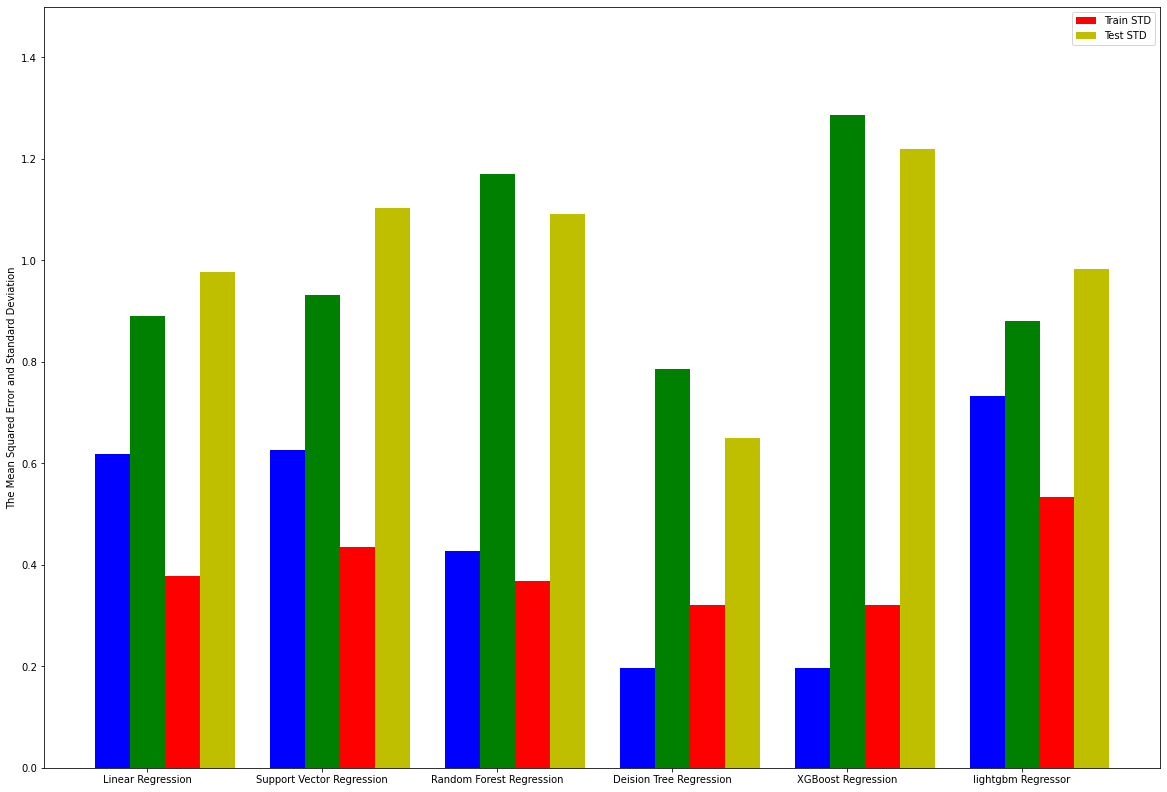

In [107]:
ind = np.arange(6)
width = 0.2

fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, train_score, width, color='b')
rects2 = ax.bar(ind+width, test_score, width, color='g')
rects3 = ax.bar(ind+2*width, train_dev, width, color='r')
rects4 = ax.bar(ind+3*width, test_dev, width, color='y')

ax.set_ylabel('The Mean Squared Error and Standard Deviation')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('Linear Regression', 'Support Vector Regression', 'Random Forest Regression','Deision Tree Regression',
                    'XGBoost Regression','lightgbm Regressor') )
ax.legend((rects1[0], rects2[0]), ('Train Mean Squared Error', 'Test Mean Squared Error'))
ax.legend((rects3[0], rects4[0]), ('Train STD', 'Test STD'))


plt.ylim((0,1.5))
plt.show()

In [108]:
train_accuracies

{'Linear Regression': [0.6176441585235596, 0.3788979851049833],
 'Polynomial Regression': [1.1995923833825202e-13, 1.5691337397658408e-13],
 'Support Vector Regression': [0.627031532422882, 0.43584836360035856],
 'Random Forest Regression': [0.42762447695830363, 0.36885002217970353],
 'Deision Tree Regression': [0.1960455833503336, 0.32105358462929984],
 'XGBoost Regression': [0.19623153238390909, 0.3212785701361746],
 'lightgbm Regressor': [0.7328815890355225, 0.5333989033018084]}

In [109]:
g = test.copy()

In [110]:
g.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,...,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,...,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,...,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,...,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,...,5.0,3.0,0,0,0,0,0,0,0,0


In [111]:
test = pre(test)

In [112]:
test.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,...,P33,P34,P35,P36,P37,Day,Year,City Group_Other,Type_FC,Type_IL
0,1,4.0,4.0,4.0,1,2,5,4,5,5,...,0,0,0,0,0,22,2011,1,1,0
1,3,4.0,4.0,4.0,2,2,5,3,4,4,...,0,0,0,0,0,77,2011,1,0,1
2,3,4.0,4.0,4.0,2,2,5,4,4,5,...,0,0,0,0,0,303,2013,0,1,0
3,2,4.0,4.0,4.0,2,3,5,4,5,4,...,0,0,0,0,0,126,2013,1,0,1
4,2,4.0,4.0,4.0,1,2,5,4,5,4,...,0,0,0,0,0,212,2013,1,1,0


In [113]:
test = test.values

In [114]:
test[:, :39] = sc.fit_transform(test[:, :39])


In [119]:
pred = sc2.inverse_transform(sv.predict(test))

In [120]:
output = pd.DataFrame({'Id': g.Id.values ,'Prediction': pred.ravel()})

filename = 'Predictions.csv'

output.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: Predictions.csv
